M3. Improve BoVW with SVM's
--

In [1]:
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from utils.CodeTimer import CodeTimer
from utils.DatasetManager import DatasetManager
from utils.Normalizer import Normalizer as Normalizer_
from descriptors.SIFT import DenseSIFT as DenseSIFT_
from descriptors.SIFT import DenseSIFTPyramid as DenseSIFTPyramid_
from descriptors.VisualWords import VisualWords as VisualWords_
from utils.Kernels import histogram_intersection_kernel
from fishervector import FisherVectorGMM

From previous week, we found that using the following parameters we obtained a precision for the test around 81.16%.

   1. Vocabulary of 128
   2. Bray Curtis Distance
   3. Dense Sift using 8 as the step and the size of the keypoints.
   4. Use LDA with 7 features.
   
This week we will try to increase this precision by using SVM. To do so we will study the following

   1. First of all, a suggestion from last activity was to mix different scales of the DenseSIFT descriptors. We tried to change the steps and the sizes a bit but selecting the same number for the step and size gave us in the end the best result. 
   
   2. Change the Vocabulary size or also known as number of clusters of the VisualWords.
   3. See how Normalization affects the results.
   4. Finetuning the SVM
   5. See if using a pyramid strategy improves the previous results
   6. Trying Fisher Vectors

In [6]:
dataset = DatasetManager('../Databases/MIT_split')
train_img_paths, train_labels, test_img_paths, test_labels = dataset.load_dataset()
SAVE_PATH = '../SavePath/'

Change the size of the DenseSIFT
--

In this experiment we will fix the vocabulary size, and we will only change the step and try different sizes of the DenseSIFT descriptors. In addition we will substitute the KNN with a SVM. We will also eliminate the LDA. 

In [6]:
N_CLUSTERS = 128
K_FOLDS = 5
PARAM_GRID = {'C': [1], 'kernel': ['rbf'], 'gamma': ['scale']}
step_sizes = [8, 16, 32]
descriptor_sizes_dict = {8: [[1],[0.5,1]], 16: [[1],[0.5,1],[0.25,0.5,0.75,1]], 32: [[1],[0.5,1],[0.25,0.5,0.75,1]]}
results_test = []
results_train = []

DenseSIFT = DenseSIFT_()
VisualWords = VisualWords_(N_CLUSTERS)
for step_size in step_sizes:
    for descriptor_sizes_ in descriptor_sizes_dict[step_size]:
        # Define descriptor sizes
        descriptor_sizes = sorted(list(set([int(i*step_size) for i in descriptor_sizes_])))
        train_desc_path = SAVE_PATH+'desc'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        test_desc_path = SAVE_PATH+'desc'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        train_data_path = SAVE_PATH+'data'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        test_data_path = SAVE_PATH+'data'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
            train_desc = pickle.load(open(train_desc_path, 'rb'))
            test_desc = pickle.load(open(test_desc_path,'rb'))
            train_data = pickle.load(open(train_data_path,'rb'))
            test_data = pickle.load(open(test_data_path,'rb'))
        else:
            with CodeTimer("Obtain training and test data"):
                # Compute DenseSIFT descriptors for train and test sets
                train_desc = DenseSIFT.compute(train_img_paths, step_size, descriptor_sizes)
                test_desc = DenseSIFT.compute(test_img_paths, step_size, descriptor_sizes)
                # Save computed data
                pickle.dump(train_desc, open(train_desc_path, 'wb'))
                pickle.dump(test_desc, open(test_desc_path, 'wb'))
                # Obtain visual words for train and test sets
                VisualWords.fit(train_desc)
                train_data = VisualWords.get_visual_words(train_desc)
                test_data = VisualWords.get_visual_words(test_desc)
                # Save computed data
                pickle.dump(train_data, open(train_data_path, 'wb'))
                pickle.dump(test_data, open(test_data_path, 'wb'))
                # Train SVM with cross-validation 5-fold
        with CodeTimer("Train SVM"):
            cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
            cv.fit(train_data, train_labels)
        # Test SVM
        with CodeTimer("Test SVM"):
            results_train.append(cv.score(train_data, train_labels))
            results_test.append(cv.score(test_data, test_labels))

Train SVM: 2.523352861404419 s
Test SVM: 0.18150997161865234 s
Obtain training and test data: 306.0814678668976 s
Train SVM: 2.12414288520813 s
Test SVM: 0.18492579460144043 s
Obtain training and test data: 176.2810640335083 s
Train SVM: 1.9751551151275635 s
Test SVM: 0.15711688995361328 s
Obtain training and test data: 216.36603903770447 s
Train SVM: 2.1164751052856445 s
Test SVM: 0.17260003089904785 s
Obtain training and test data: 314.469685792923 s
Train SVM: 1.8273940086364746 s
Test SVM: 0.1612539291381836 s
Obtain training and test data: 111.42421984672546 s
Train SVM: 2.0699920654296875 s
Test SVM: 0.1585249900817871 s
Obtain training and test data: 145.2274830341339 s
Train SVM: 1.9113810062408447 s
Test SVM: 0.15057086944580078 s
Obtain training and test data: 218.12727189064026 s
Train SVM: 1.8377351760864258 s
Test SVM: 0.16202020645141602 s


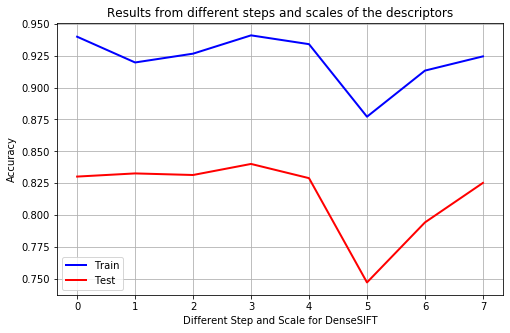

In [27]:
plt.figure(figsize=(8, 5))
plt.title('Results from different steps and scales of the descriptors')
plt.plot(results_train,'b',linewidth=2,label='Train')
plt.plot(results_test,'r',linewidth=2,label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Different Step and Scale for DenseSIFT')
plt.legend()
plt.grid(True)
plt.show()

To explain this graph we have tried for different step sizes different sizes. So for the steps we have tried 8,16 and 32. Then for each one we have tried the scales to be first the same as the step, then adding $\frac{step}{2}$ and finally adding $\frac{3 \cdot step}{4}$ and $\frac{step}{4}$.  

We present here the X Axis:

0. Step: 8 -- Scales: 8
1. Step: 8 -- Scales: 4-8
2. Step: 16 -- Scales: 16
3. Step: 16 -- Scales: 8-16
4. Step: 16 -- Scales: 4-8-12-16
5. Step: 32 -- Scales: 32
6. Step: 32 -- Scales: 16-32
7. Step: 32 -- Scales: 8-16-24-32

Conclusion: 

As the graph shows using small step size generally works better than taking big step sizes. Then taking different scales we see that tends to improve the results. For computation cost we have decided to use a step size of 16 and scales of 8 and 16 for our descriptors.

We also see a consistent difference between the train accuracy and the test accuracy, which seems to us that could be reduced when taking into account the regularization parameter of the SVM.

Change the number of Clusters or the Vocabulary size
--

For this experiment now we will try different number of clusters

In [19]:
STEP_SIZE = 16
DESC_SIZE = [8,16]
N_CLUSTERS = [128, 256, 384, 512, 640, 768, 896, 1024]
results_test = []
results_train = []

DenseSIFT = DenseSIFT_()
for n_cluster in N_CLUSTERS:
    VisualWords = VisualWords_(n_cluster)
    train_desc_path = SAVE_PATH+'desc'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_desc_path = SAVE_PATH+'desc'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    train_data_path = SAVE_PATH+'data'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_data_path = SAVE_PATH+'data'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
        train_desc = pickle.load(open(train_desc_path, 'rb'))
        test_desc = pickle.load(open(test_desc_path,'rb'))
        train_data = pickle.load(open(train_data_path,'rb'))
        test_data = pickle.load(open(test_data_path,'rb'))
    else:
        with CodeTimer("Obtain training and test data"):
            # Compute DenseSIFT descriptors for train and test sets
            train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE)
            test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE)
            # Save computed data
            pickle.dump(train_desc, open(train_desc_path, 'wb'))
            pickle.dump(test_desc, open(test_desc_path, 'wb'))
            # Obtain visual words for train and test sets
            VisualWords.fit(train_desc)
            train_data = VisualWords.get_visual_words(train_desc)
            test_data = VisualWords.get_visual_words(test_desc)
            # Save computed data
            pickle.dump(train_data, open(train_data_path, 'wb'))
            pickle.dump(test_data, open(test_data_path, 'wb'))
            # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
        cv.fit(train_data, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data, train_labels)) 
        results_test.append(cv.score(test_data, test_labels)) 

Obtain training and test data: 40.542662143707275 s
Train SVM: 2.670769214630127 s
Test SVM: 0.20858502388000488 s
Obtain training and test data: 53.31530809402466 s
Train SVM: 5.075722932815552 s
Test SVM: 0.4352397918701172 s
Obtain training and test data: 72.8689751625061 s
Train SVM: 7.793022871017456 s
Test SVM: 0.6836180686950684 s
Obtain training and test data: 117.54529309272766 s
Train SVM: 10.785996198654175 s
Test SVM: 0.8818421363830566 s
Obtain training and test data: 183.32933926582336 s
Train SVM: 13.98125410079956 s
Test SVM: 1.1225290298461914 s
Obtain training and test data: 243.6653392314911 s
Train SVM: 17.40980315208435 s
Test SVM: 1.5564053058624268 s
Obtain training and test data: 300.5999069213867 s
Train SVM: 20.803389072418213 s
Test SVM: 1.5164148807525635 s
Obtain training and test data: 355.8561749458313 s
Train SVM: 24.697921991348267 s
Test SVM: 1.8541321754455566 s


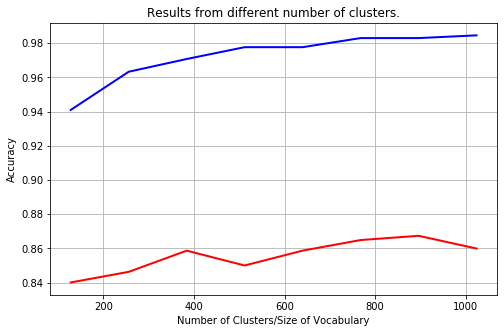

In [29]:
plt.figure(figsize=(8, 5))
plt.title('Results from different number of clusters.')
plt.plot(N_CLUSTERS,results_train,'b',linewidth=2,label='Test')
plt.plot(N_CLUSTERS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

Conclusion:
    
In this graph we can appreciate that using now more clusters helps the SVM to increase the accuracy from 81.16% to more than 86% (86.74% to be exacts) which is great. Until this point we have been using the default parameters of the SVM which are:

1. C -- (Regularization parameter): 1
2. kernel -- (Specifies the kernel): RBF
3. gamma -- (Kernel coefficient): scale
5. decision_function_shape -- (Whether to return a one-vs-rest or other settings): ovr

How Normalization affects the results
--

In this experiment we are going to normalize the data and then see if the normalization actually improves the results versus not applying it. We will try 3 types of normalizations:
   1. L1
   2. L2
   3. Power
   
Apart from these normalizations we will also normalize in mean and variance the data using a class from sklearn call _Standard Scalar_

In [9]:
N_CLUSTERS = 896
STEP_SIZE = 16
DESC_SIZE = [8,16]
K_FOLDS = 5
PARAM_GRID = {'C': [1], 'kernel': ['rbf'], 'gamma': ['scale']}
NORMALIZATIONS = ["l1","l2","power"]

In [10]:
results_train = []
results_test = []

DenseSIFT = DenseSIFT_()
scaler = StandardScaler()
VisualWords = VisualWords_(N_CLUSTERS)
Normalizer = Normalizer_()

train_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
train_data_path = SAVE_PATH+os.sep+'data'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_data_path = SAVE_PATH+os.sep+'data'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
    train_desc = pickle.load(open(train_desc_path, 'rb'))
    test_desc = pickle.load(open(test_desc_path,'rb'))
    train_data = pickle.load(open(train_data_path,'rb'))
    test_data = pickle.load(open(test_data_path,'rb'))
else:
    with CodeTimer("Obtain training and test data"):
        # Compute DenseSIFT descriptors for train and test sets
        train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE, 2)
        test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE, 2)
        # Save computed data
        pickle.dump(train_desc, open(train_desc_path, 'wb'))
        pickle.dump(test_desc, open(test_desc_path, 'wb'))
        # Obtain visual words for train and test sets
        VisualWords.fit(train_desc)
        train_data = VisualWords.get_visual_words(train_desc)
        test_data = VisualWords.get_visual_words(test_desc)
        # Save computed data
        pickle.dump(train_data, open(train_data_path, 'wb'))
        pickle.dump(test_data, open(test_data_path, 'wb'))
for norm in NORMALIZATIONS:
    # Normalize data
    train_data_norm = Normalizer.normalize(train_data, norm)
    test_data_norm = Normalizer.normalize(test_data, norm)
    # Scale data
    train_data_norm = scaler.fit_transform(train_data_norm)
    test_data_norm = scaler.transform(test_data_norm)
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
        cv.fit(train_data_norm, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data_norm, train_labels)) 
        results_test.append(cv.score(test_data_norm, test_labels))

Train SVM: 28.611683130264282 s
Test SVM: 5.206831932067871 s
Train SVM: 27.188402891159058 s
Test SVM: 5.178617238998413 s
Train SVM: 28.08722472190857 s
Test SVM: 5.254977703094482 s


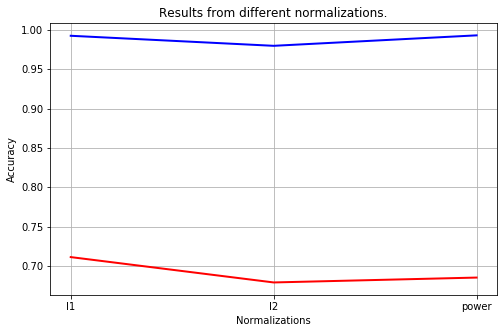

In [11]:
plt.figure(figsize=(8, 5))
plt.title('Results from different normalizations.')
plt.plot(NORMALIZATIONS,results_train,'b',linewidth=2,label='Test')
plt.plot(NORMALIZATIONS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Normalizations')
plt.grid(True)
plt.show()

Conclusions: 

Observing this graph we can see that the L1 normalization seems to work better than the other normalizations. However, we see a significant drop in performance compared with previous test. We have to be careful because this test has been computed using the vanilla SVM, so maybe adjusting the SVM we achieve to imporve the results, so from here L1 normalization will be applied.

Finetuning the SVM
--

To finetune the SVM we have three main parameters to test:

1. C: Regularizer constant
2. Kernel: type of kernel used
3. tol: Tolerance, value to adjust the level of tolerance on accepting errors.

For the C we will try low, mid and high values using a logarithmic scale. For the tolerance we will use values between 0 and 1. Finally for the kernels we will be using the default 'rbf', 'linear', 'sigmoid' and our implementation of the ***histogram intersection kernel***:  

```python
def histogram_intersection_kernel(a, b):
    K = np.empty(shape=(a.shape[0], b.shape[0]), dtype=np.float32)
    for i in range(a.shape[0]):
        K[i] = np.sum(np.minimum(a[i], b), axis=1)
    return K
```

In [12]:
N_CLUSTERS = 896
STEP_SIZE = 16
DESC_SIZE = [8,16]
K_FOLDS = 5
C = np.logspace(-4,4,15,base=10).tolist()
TOLERANCE = np.logspace(-3,0,10,base=2).tolist()

In [28]:
DenseSIFT = DenseSIFT_()
scaler = StandardScaler()
VisualWords = VisualWords_(N_CLUSTERS)
train_desc_path = SAVE_PATH+'desc'+os.sep+'train_exp_2.dat'
test_desc_path = SAVE_PATH+'desc'+os.sep+'test_exp_2.dat'
train_data_path = SAVE_PATH+'data'+os.sep+'train_exp_2.dat'
test_data_path = SAVE_PATH+'data'+os.sep+'test_exp_2.dat'
with CodeTimer("Obtain training and test data"):
    # Check for existing data files already computed
    if all(os.path.isfile(path) for path in [train_data_path, test_data_path, train_desc_path, test_desc_path]):
        train_data = pickle.load(open(train_data_path, 'rb'))
        test_data = pickle.load(open(test_data_path, 'rb'))
        train_desc = pickle.load(open(train_data_path, 'rb'))
        test_desc = pickle.load(open(test_data_path, 'rb'))
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)
    else:
        # Compute DenseSIFT descriptors for train and test sets
        train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE)
        test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE)
        # Save computed data
        pickle.dump(train_desc, open(train_desc_path, 'wb'))
        pickle.dump(test_desc, open(test_desc_path, 'wb'))
        # Obtain visual words for train and test sets
        VisualWords.fit(train_desc)
        train_data = VisualWords.get_visual_words(train_desc)
        test_data = VisualWords.get_visual_words(test_desc)
        # Save computed data
        pickle.dump(train_data, open(train_data_path, 'wb'))
        pickle.dump(test_data, open(test_data_path, 'wb'))

results_train = []
results_test = []
C = np.logspace(-4,4,15,base=10).tolist()
GAMMA = ['scale']
KERNEL = [histogram_intersection_kernel]
TOL = [1e-3]
for c in C:
    # Normalize data
    train_data_norm = Normalizer.normalize(train_data, 'l1')
    test_data_norm = Normalizer.normalize(test_data, 'l1')
    # Scale data
    train_data_norm = scaler.fit_transform(train_data_norm)
    test_data_norm = scaler.transform(test_data_norm)
    PARAMETERS = {'C':[c],'gamma':GAMMA,'kernel':KERNEL,'tol': TOLERANCE}
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAMETERS, cv=K_FOLDS, verbose=5, n_jobs=-1)
        cv.fit(train_data_norm, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data_norm, train_labels)) 
        results_test.append(cv.score(test_data_norm, test_labels)) 

Obtain training and test data: 0.10731077194213867 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.3min finished


Train SVM: 331.84140968322754 s
Test SVM: 22.50127911567688 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.4min finished


Train SVM: 338.90132784843445 s
Test SVM: 22.799152135849 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Train SVM: 354.8057768344879 s
Test SVM: 22.16109585762024 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


Train SVM: 323.64914107322693 s
Test SVM: 21.932013034820557 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.4min finished


Train SVM: 341.06829285621643 s
Test SVM: 22.34979796409607 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


Train SVM: 342.7166039943695 s
Test SVM: 22.497880935668945 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished


Train SVM: 367.93542408943176 s
Test SVM: 22.06014394760132 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


Train SVM: 364.5730230808258 s
Test SVM: 22.386289358139038 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Train SVM: 351.5926969051361 s
Test SVM: 22.023789167404175 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Train SVM: 353.201455116272 s
Test SVM: 22.102097988128662 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished


Train SVM: 360.98431396484375 s
Test SVM: 23.099926948547363 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Train SVM: 350.1984758377075 s
Test SVM: 21.744431734085083 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Train SVM: 351.5910189151764 s
Test SVM: 22.363191843032837 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


Train SVM: 364.8513000011444 s
Test SVM: 22.740920066833496 s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.0min finished


Train SVM: 373.90798473358154 s
Test SVM: 22.277430772781372 s


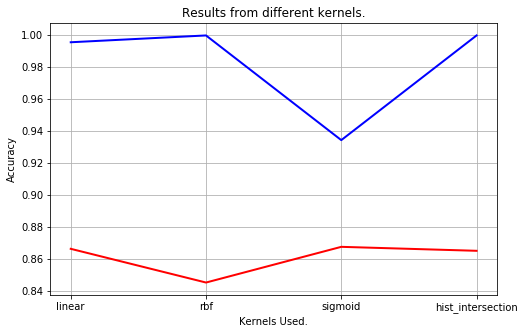

In [23]:
KERNEL = ["linear", "rbf", "sigmoid", "hist_intersection"]
plt.figure(figsize=(8, 5))
plt.title('Results from different kernels.')
plt.plot(KERNEL,results_train,'b',linewidth=2,label='Test')
plt.plot(KERNEL,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Kernels Used')
plt.grid(True)
plt.show()

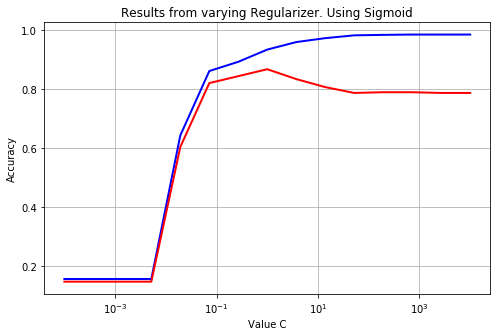

In [27]:
plt.figure(figsize=(8, 5))
plt.title('Results from varying Regularizer. Using Sigmoid')
plt.plot(C,results_train,'b',linewidth=2,label='Test')
plt.plot(C,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=10)
plt.ylabel('Accuracy')
plt.xlabel('Value C')
plt.grid(True)
plt.show()

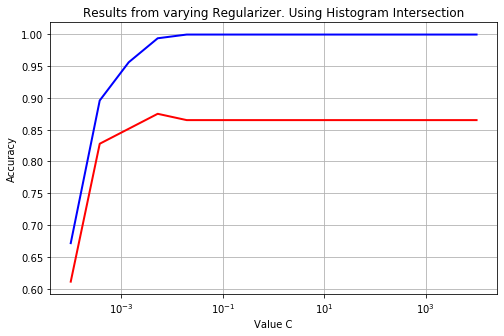

In [29]:
plt.figure(figsize=(8, 5))
plt.title('Results from varying Regularizer. Using Histogram Intersection')
plt.plot(C,results_train,'b',linewidth=2,label='Test')
plt.plot(C,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=10)
plt.ylabel('Accuracy')
plt.xlabel('Value C')
plt.grid(True)
plt.show()

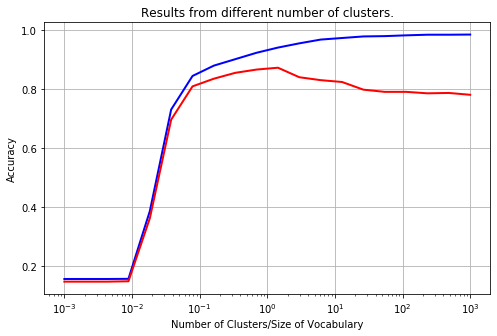

In [69]:
plt.figure(figsize=(8, 5))
plt.title('Results from different number of clusters.')
plt.plot(C,results_train,'b',linewidth=2,label='Test')
plt.plot(C,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=10)
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

Conclusions:



Pyramid
--

BLABLACAR

In [ ]:
#codi pyramid

conclusions

FISHER
--

BLABLACAR

In [ ]:
#code fisher

In [ ]:
conclusions

FINAL RESULTS
--

SUMMARY

In [ ]:
#code final

Conclusions